In [1]:
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils import data
import seaborn as sns

In [2]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, act_layer=nn.GELU, drop=0., pred=True):
        super().__init__()
        # 定义线性层，将输入进行计算
        hidden_features = hidden_features or in_features
        self.q = nn.Linear(in_features, in_features)
        self.k = nn.Linear(in_features, in_features)
        self.v = nn.Linear(in_features, in_features)
        # 定义全连接层，作为MLP中的隐藏层
        self.fc1 = nn.Linear(in_features, hidden_features)
        # 激活函数
        self.act = act_layer()
        # 是否存在输出层
        self.pred = pred
        if pred==True:
            # 预测模式下，输出层为单一的线性层
            self.fc2 = nn.Linear(hidden_features,1)
        else:
            # 训练模式下，输出层为与输入形状相同的线性层
            self.fc2 = nn.Linear(hidden_features, in_features)
        # 定义Dropout层，防止过拟合
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x0 = x
        # 计算Attention分布
        q = self.q(x).unsqueeze(2)
        k = self.k(x).unsqueeze(2)
        v = self.v(x).unsqueeze(2)
        attn = (q @ k.transpose(-2, -1))
        attn = attn.softmax(dim=-1)
        # 计算加权和
        x = (attn @ v).squeeze(2)
        x += x0
        # 计算MLP中的隐藏层与输出层
        x1 = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        # 如果不存在输出层，则将输出与输入相加
        if self.pred==False:
            x += x1
        x = x.squeeze(0)
        # 返回输出值
        return x

In [3]:
class TF(nn.Module):
    def __init__(self, in_features, drop=0.):
        super().__init__()
        # 定义多层MLP结构，包括一个隐藏层和一个输出层
        self.Block1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_2 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_3 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        self.Block2 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=True)

    def forward(self, x):
        # 前向传播，将输入经过多层MLP结构得到输出
        return self.Block2(self.Block1(x))

In [4]:
#Import Data
train_raw = pd.read_csv('../data/train.csv')
test_raw = pd.read_csv('../data/test.csv')

In [5]:
print(train_raw.shape, test_raw.shape)
print(train_raw.iloc[0:4,[0,1,2,3,-3,-2,-1]])

(1460, 81) (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [6]:
all_features_raw = pd.concat((train_raw.iloc[:,1:-1], test_raw.iloc[:,1:]))
all_features = all_features_raw.copy()

In [7]:
# 数据处理 填充非法值
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

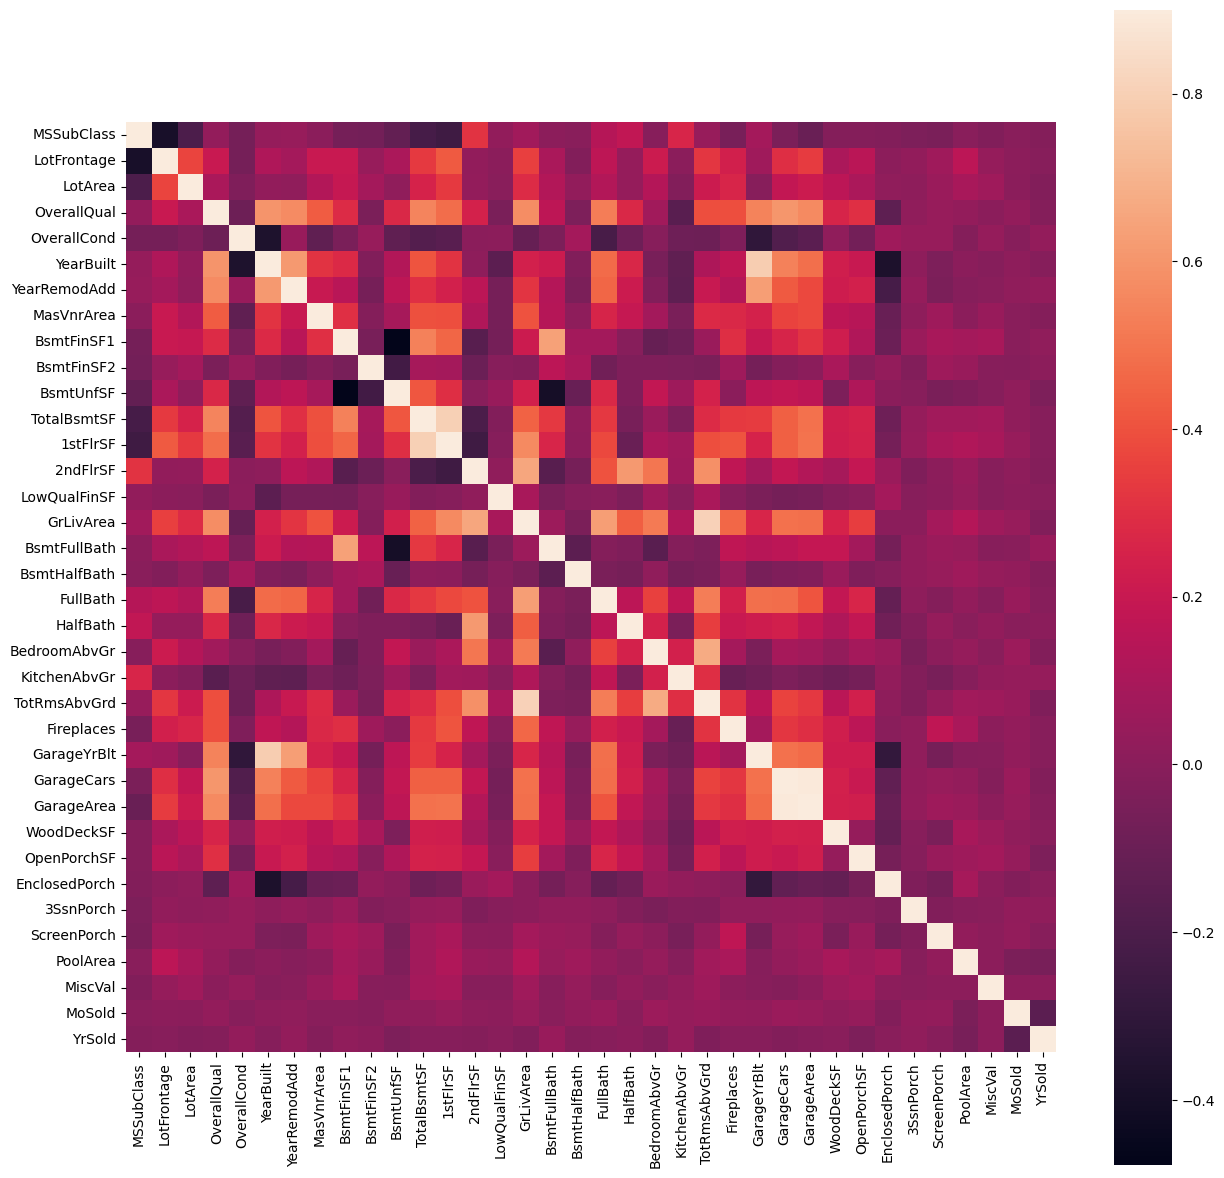

In [8]:
corrmat = all_features.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.savefig('./corr.png')
plt.show()

In [9]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)
print(all_features)

(2919, 331)
      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1      -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2       0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3       0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
4       0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
...          ...          ...       ...          ...          ...        ...   
1454    2.419286    -2.069222 -1.043758    -1.481667     1.289537  -0.043338   
1455    2.419286    -2.069222 -1.049083    -1.481667    -0.507197  -0.043338   
1456   -0.873466     3.884968  1.246594    -0.772420     1.289537  -0.373465   
1457    0.655311    -0.312950  0.034599    -0.772420    -0.507197   0.682939   
1458    0.067320     0.201080 -0.068608     0.646073    -0.507197   0.715952   

      YearRemodAdd  MasVnrA

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_train = train_raw.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32).to(device)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_raw.SalePrice.values.reshape(-1,1), dtype=torch.float32).to(device)

In [11]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

In [13]:
def get_net():
    #net = nn.Sequential(nn.Linear(in_features, 64), nn.ReLU(), nn.Linear(64,1)).to(device)
    net = TF(in_features=331, drop=0.).to(device)
    return net

In [21]:
a=get_net()

In [22]:
a

TF(
  (Block1): Mlp(
    (q): Linear(in_features=331, out_features=331, bias=True)
    (k): Linear(in_features=331, out_features=331, bias=True)
    (v): Linear(in_features=331, out_features=331, bias=True)
    (fc1): Linear(in_features=331, out_features=64, bias=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=64, out_features=331, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (Block2): Mlp(
    (q): Linear(in_features=331, out_features=331, bias=True)
    (k): Linear(in_features=331, out_features=331, bias=True)
    (v): Linear(in_features=331, out_features=331, bias=True)
    (fc1): Linear(in_features=331, out_features=64, bias=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
)

In [14]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [17]:
# ##### K-fold cross-validation
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [18]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [19]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, valid_ls = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    train_ls_all = []
    train_ls_all.append(train_ls)
    plt.plot(np.arange(1,101,1),train_ls_all[0])
    plt.xlabel('epoch'), plt.ylabel('rmse')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).cpu().detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.002, 2, 64

In [43]:
print("K-fold Validation:\n")
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

K-fold Validation:

fold 1, train log rmse 0.020707, valid log rmse 0.121471
fold 2, train log rmse 0.014416, valid log rmse 0.135601
fold 3, train log rmse 0.014130, valid log rmse 0.129008
fold 4, train log rmse 0.034849, valid log rmse 0.124477
fold 5, train log rmse 0.010119, valid log rmse 0.133267
5-fold validation: avg train log rmse: 0.018844, avg valid log rmse: 0.128765


train log rmse 0.014795


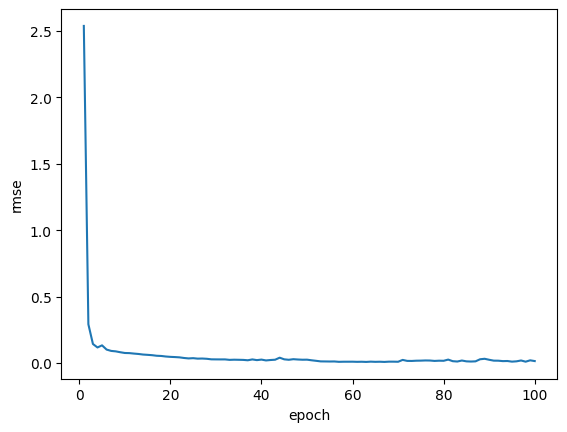

In [46]:
train_and_pred(train_features, test_features, train_labels, test_raw,
               num_epochs, lr, weight_decay, batch_size)


lr:0.00010
train log rmse 0.065720

lr:0.00020
train log rmse 0.033794

lr:0.00030
train log rmse 0.013559

lr:0.00040
train log rmse 0.014775

lr:0.00050
train log rmse 0.010046

lr:0.00060
train log rmse 0.009978

lr:0.00070
train log rmse 0.014721

lr:0.00080
train log rmse 0.008370

lr:0.00090
train log rmse 0.010396

lr:0.00100
train log rmse 0.004784

lr:0.00110
train log rmse 0.009341

lr:0.00120
train log rmse 0.012538

lr:0.00130
train log rmse 0.017378

lr:0.00140
train log rmse 0.012742

lr:0.00150
train log rmse 0.012919

lr:0.00160
train log rmse 0.012228

lr:0.00170
train log rmse 0.009359

lr:0.00180
train log rmse 0.013645

lr:0.00190
train log rmse 0.010449

lr:0.00200
train log rmse 0.010841

lr:0.00210
train log rmse 0.009099

lr:0.00220
train log rmse 0.008002

lr:0.00230
train log rmse 0.014530

lr:0.00240
train log rmse 0.014476

lr:0.00250
train log rmse 0.005482

lr:0.00260
train log rmse 0.004524

lr:0.00270
train log rmse 0.009990

lr:0.00280
train log rmse 0

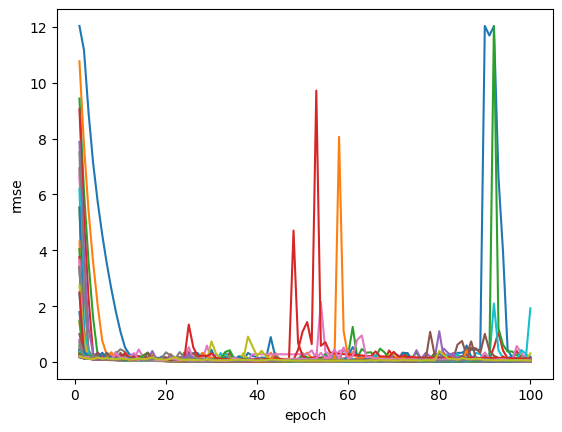

In [47]:
#Better Version
lr_range = np.arange(0.0001, 0.01, 0.0001).tolist()
for lr in lr_range:
    print('\nlr:{:.5f}'.format(lr))
    train_and_pred(train_features, test_features, train_labels, test_raw,
               num_epochs, lr, weight_decay, batch_size)